In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from raindisagg_gan_pretrained import generate_scenarios, plot_scenarios
from scipy.stats import moment
import scipy.stats as sp
import pandas as pd
import warnings

In [2]:
data_verano = xr.open_mfdataset('data_verano.nc')
data_primavera = xr.open_mfdataset('data_primavera.nc')
data_invierno = xr.open_mfdataset('data_invierno.nc')
data_otono = xr.open_mfdataset('data_otono.nc')

/home/pablo/mambaforge/envs/pr-disagg-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/pablo/mambaforge/envs/pr-disagg-env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/pablo/mambaforge/envs/pr

In [3]:
ds_daily_verano = data_verano.resample(time = 'D').sum()
ds_daily_invierno = data_invierno.resample(time = 'D').sum()
ds_daily_primavera = data_primavera.resample(time = 'D').sum()
ds_daily_otono = data_otono.resample(time = 'D').sum()

## Filtar datos diarios

In [4]:
# Filtrar los días sin NaN
data_no_nan = ds_daily_verano.dropna(dim='time', how='any')

# Calcular la suma de valores en la matriz 16x16
sum_values = data_no_nan['__xarray_dataarray_variable__'].sum(dim=('x', 'y'))

# Filtrar los días con suma mayor que 5
filtered_data_verano = data_no_nan.sel(time=sum_values > 5)



# Filtrar los días sin NaN
data_no_nan = ds_daily_invierno.dropna(dim='time', how='any')

# Calcular la suma de valores en la matriz 16x16
sum_values = data_no_nan['__xarray_dataarray_variable__'].sum(dim=('x', 'y'))

# Filtrar los días con suma mayor que 5
filtered_data_invierno = data_no_nan.sel(time=sum_values > 5)



# Filtrar los días sin NaN
data_no_nan = ds_daily_primavera.dropna(dim='time', how='any')

# Calcular la suma de valores en la matriz 16x16
sum_values = data_no_nan['__xarray_dataarray_variable__'].sum(dim=('x', 'y'))

# Filtrar los días con suma mayor que 5
filtered_data_primavera = data_no_nan.sel(time=sum_values > 5)



# Filtrar los días sin NaN
data_no_nan = ds_daily_otono.dropna(dim='time', how='any')

# Calcular la suma de valores en la matriz 16x16
sum_values = data_no_nan['__xarray_dataarray_variable__'].sum(dim=('x', 'y'))

# Filtrar los días con suma mayor que 5
filtered_data_otono = data_no_nan.sel(time=sum_values > 5)

## Filtrar datos horarios

In [5]:
# Filtrar los días sin NaN
data_no_nan = data_verano.dropna(dim='time', how='any')

# Filtrar los días con suma mayor que 5
filtered_data_verano_hourly = data_no_nan



# Filtrar los días sin NaN
data_no_nan = data_invierno.dropna(dim='time', how='any')


# Filtrar los días con suma mayor que 5
filtered_data_invierno_hourly = data_no_nan



# Filtrar los días sin NaN
data_no_nan = data_primavera.dropna(dim='time', how='any')




# Filtrar los días con suma mayor que 5
filtered_data_primavera_hourly = data_no_nan



# Filtrar los días sin NaN
data_no_nan = data_otono.dropna(dim='time', how='any')



# Filtrar los días con suma mayor que 5
filtered_data_otono_hourly = data_no_nan

## Seleccionar menos datos si fuera necesario

In [6]:
filtered_data_verano = filtered_data_verano.sel(time=filtered_data_verano.time[:50])
filtered_data_invierno = filtered_data_invierno.sel(time=filtered_data_invierno.time[:50])
filtered_data_otono = filtered_data_otono.sel(time=filtered_data_otono.time[:50])
filtered_data_primavera = filtered_data_primavera.sel(time=filtered_data_primavera.time[:50])

## Ficheros

In [7]:
filtered_data = {
    'primavera': filtered_data_primavera,
    'verano': filtered_data_verano,
    'otono': filtered_data_otono,
    'invierno': filtered_data_invierno
}

## Escenarios

In [8]:
datasets = {
    'verano': filtered_data_verano,
    'otono': filtered_data_otono,
    'invierno': filtered_data_invierno,
    'primavera': filtered_data_primavera
}

ndomain = 16
n_scenarios = 10

result_arrays = {}

for name, ds in datasets.items():
    all_scenarios = []
    
    for day in ds.time:
        values_for_day = ds.sel(time=day)['__xarray_dataarray_variable__'].values
        cond = np.expand_dims(values_for_day, axis=-1)
        scenarios = generate_scenarios(cond, n_scenarios)
        all_scenarios.append(scenarios)
    
    scenarios_array = np.array(all_scenarios)
    result_arrays[name] = scenarios_array

# `result_arrays` contendrá los 4 arrays, cada uno con un nombre distinto
for name, scenarios_array in result_arrays.items():
    print(f"Shape of scenarios array for {name}: {scenarios_array.shape}")


Shape of scenarios array for verano: (50, 10, 24, 16, 16)
Shape of scenarios array for otono: (50, 10, 24, 16, 16)
Shape of scenarios array for invierno: (50, 10, 24, 16, 16)
Shape of scenarios array for primavera: (50, 10, 24, 16, 16)


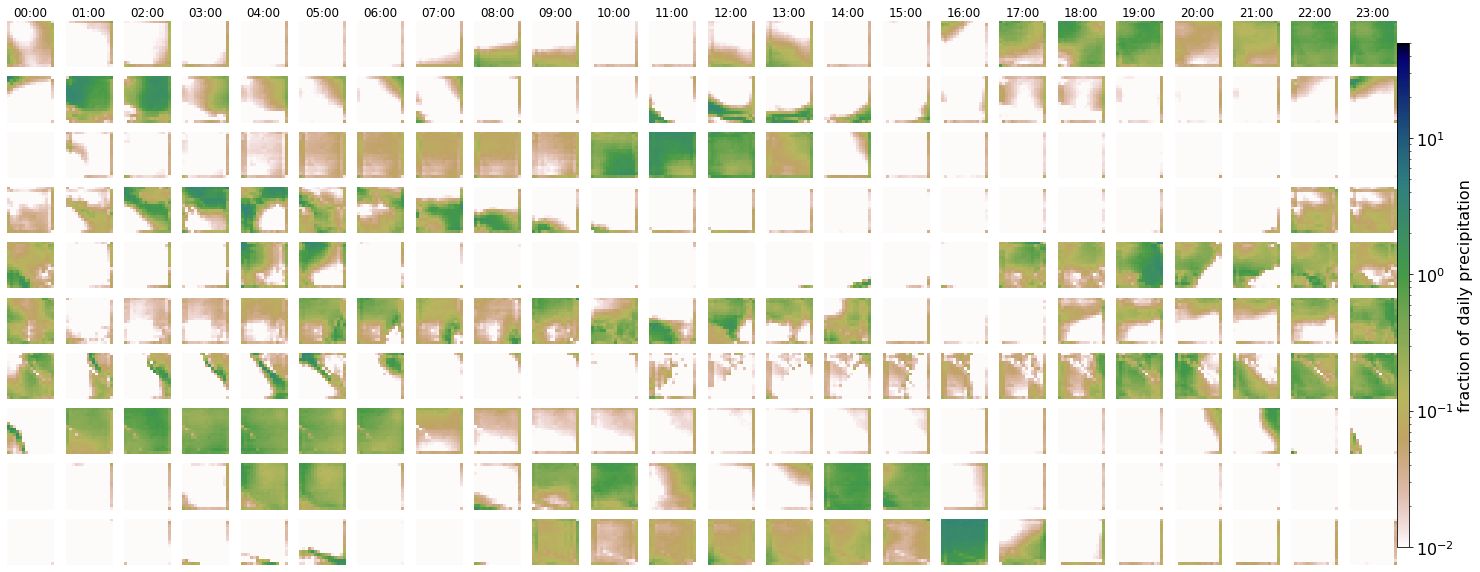

In [9]:
fig=plot_scenarios(result_arrays['verano'][0,])
plt.savefig('generated_scenario.png')

## Media

In [9]:
conjuntos_datos_estaciones = {
    'primavera': data_primavera,
    'verano': data_verano,
    'otono': data_otono,
    'invierno': data_invierno
}

# Crear una lista de las estaciones
estaciones = list(result_arrays.keys())

# Inicializar diccionarios para almacenar los resultados
media_datasets = {}
max_media_datasets = {}
min_media_datasets = {}
media_real = {}


# Iterar a través de las estaciones y sus datos correspondientes
for estacion in estaciones:
    ####### COMÚN
    estacion_data = result_arrays[estacion]
    conjunto_datos = conjuntos_datos_estaciones[estacion]
    
    # Obtener valores de coordenadas x e y
    x_values = filtered_data_verano['x'].values
    y_values = filtered_data_verano['y'].values
    
    ###################### Media
    
    # Calcular la varianza para cada escenario en la estación
    media = np.mean(estacion_data, axis=(2, 0))
    max_media = np.max(media, axis=0)
    min_media = np.min(media, axis=0)
    print(media.shape)
    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    media_xarray = xr.DataArray(media[5], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_media_xarray = xr.DataArray(max_media, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_media_xarray = xr.DataArray(min_media, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    media_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': media_xarray})
    max_media_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_media_xarray})
    min_media_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_media_xarray})
    
    # Calcular la varianza para datos reales
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    #real_data = conjunto_datos.sel(time=conjunto_datos.time)
    media_real[estacion] = real_data.mean(dim='time')
    
    

(10, 16, 16)
(10, 16, 16)
(10, 16, 16)
(10, 16, 16)


## Varianza y M3

In [10]:
conjuntos_datos_estaciones = {
    'primavera': data_primavera,
    'verano': data_verano,
    'otono': data_otono,
    'invierno': data_invierno
}

# Crear una lista de las estaciones
estaciones = list(result_arrays.keys())

# Inicializar diccionarios para almacenar los resultados
varianza_datasets = {}
max_varianza_datasets = {}
min_varianza_datasets = {}
varianza_real = {}

skewness_datasets = {}
max_skewness_datasets = {}
min_skewness_datasets = {}
skewness_real = {}


def M3(Data):
    return sp.stats.moment(Data, moment=3, nan_policy='omit')

# Iterar a través de las estaciones y sus datos correspondientes
for estacion in estaciones:
    ####### COMÚN
    estacion_data = result_arrays[estacion]
    conjunto_datos = conjuntos_datos_estaciones[estacion]
    
    # Obtener valores de coordenadas x e y
    x_values = filtered_data_verano['x'].values
    y_values = filtered_data_verano['y'].values
    
    ###################### VARIANZA
    
    # Calcular la varianza para cada escenario en la estación
    varianza = np.var(estacion_data, axis=(2, 0))
    max_varianza = np.max(varianza, axis=0)
    min_varianza = np.min(varianza, axis=0)
    print(varianza.shape)
    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    variance_xarray = xr.DataArray(varianza[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_variance_xarray = xr.DataArray(max_varianza, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_variance_xarray = xr.DataArray(min_varianza, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    varianza_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': variance_xarray})
    max_varianza_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_variance_xarray})
    min_varianza_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_variance_xarray})
    
    # Calcular la varianza para datos reales
    #real_data = conjunto_datos.sel(time=conjunto_datos.time)
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    varianza_real[estacion] = real_data.var(dim='time')
    
    ########################### SKEWNESS
    
    # Calcular skewness para cada escenario en la estación
    skewness = moment(estacion_data, moment=3, axis=(2, 0))
    max_skewness = np.max(skewness, axis=0)
    min_skewness = np.min(skewness, axis=0)

    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    skewness_xarray = xr.DataArray(skewness[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_skewness_xarray = xr.DataArray(max_skewness, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_skewness_xarray = xr.DataArray(min_skewness, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    skewness_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': skewness_xarray})
    max_skewness_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_skewness_xarray})
    min_skewness_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_skewness_xarray})
     
    # Calcular la varianza para el rango de tiempo específico 'quepasara'
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    #skewness_real[estacion] = real_data.var(dim='time')
    # Convertir a arreglo NumPy
    real_data_values = real_data['__xarray_dataarray_variable__'].values

    # Aplicar la función M3 a lo largo de la dimensión 'time'
    m3_result = np.apply_along_axis(M3, axis=0, arr=real_data_values)

    # Crear un nuevo DataArray a partir del resultado y las coordenadas 'x' e 'y'
    skewness_real_array = xr.DataArray(m3_result, coords={'x': x_values, 'y': y_values}, dims=('y', 'x'))

    # Crear un nuevo Dataset con el nuevo DataArray
    skewness_real[estacion] = xr.Dataset({'__xarray_dataarray_variable__': skewness_real_array})
    



(10, 16, 16)
(10, 16, 16)
(10, 16, 16)
(10, 16, 16)


## f1_h, f1_WW. f1_DD

In [11]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def fi_h(Datos, h, temporal_resolution):
    if temporal_resolution == 'D':
        tt = 0.1
    elif temporal_resolution == 'h':    
        tt = 0.001
    return np.sum(moving_average(Datos, h) <= tt) / (np.sum(Datos >= 0))

def fi_DD(Datos, h, temporal_resolution):
    """(7, 8, 9). Cowperwait, 1995. Stochastic point process modelling of rainfall. I. 
    single-site fitting and validation. NSRP"""
    return fi_h(Datos, 2*h, temporal_resolution) / fi_h(Datos, h, temporal_resolution)
    
def fi_WW(Datos, h, temporal_resolution):
    """(7, 8, 9). Cowperwait, 1995. Stochastic point process modelling of rainfall. I. 
    single-site fitting and validation. NSRP"""
    numerator = 1 - 2 * fi_h(Datos, h, temporal_resolution) + fi_h(Datos, 2*h, temporal_resolution)
    denominator = 1 - fi_h(Datos, h, temporal_resolution)
    return numerator / denominator

conjuntos_datos_estaciones = {
    'primavera': data_primavera,
    'verano': data_verano,
    'otono': data_otono,
    'invierno': data_invierno
}

f1_h_datasets = {} 
max_f1_h_datasets = {}
min_f1_h_datasets = {}
f1_h_real_datasets={}

f1_WW_datasets = {} 
max_f1_WW_datasets = {}
min_f1_WW_datasets = {}
f1_WW_real_datasets={}

f1_DD_datasets = {} 
max_f1_DD_datasets = {}
min_f1_DD_datasets = {}
f1_DD_real_datasets={}
    
    
# Crear una lista de las estaciones
estaciones = list(result_arrays.keys())

for estacion in estaciones:
    ####### COMÚN
    estacion_data = result_arrays[estacion]
    conjunto_datos = conjuntos_datos_estaciones[estacion]
    
    # Obtener valores de coordenadas x e y
    x_values = filtered_data_verano['x'].values
    y_values = filtered_data_verano['y'].values
    
    # Aplicar la función fi_h a lo largo de las dimensiones (50, 24)
    resultado_array_f1_h = np.zeros((10, 16, 16))
    for i in range(10):
        for j in range(16):
            for k in range(16):
                resultado_array_f1_h[i, j, k] = fi_h(estacion_data[:, :, j, k], h=1, temporal_resolution='h')
    
    
    # Calcular la varianza para cada escenario en la estación
    max_f1_h = np.max(resultado_array_f1_h, axis=0)
    min_f1_h = np.min(resultado_array_f1_h, axis=0)
    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    f1_h_xarray = xr.DataArray(resultado_array_f1_h[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_f1_h_xarray = xr.DataArray(max_f1_h, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_f1_h_xarray = xr.DataArray(min_f1_h, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    f1_h_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_h_xarray})
    max_f1_h_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_f1_h_xarray})
    min_f1_h_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_f1_h_xarray})
    
    # Calcular la varianza para el rango de tiempo específico 'quepasara'
    #real_data = conjunto_datos.sel(time=conjunto_datos.time)
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    
    # Convertir a arreglo NumPy
    real_data_values = real_data['__xarray_dataarray_variable__'].values
    
    f1_h_real_array = np.zeros((16, 16))
    for j in range(16):
        for k in range(16):
            f1_h_real_array[j, k] = fi_h(real_data_values[:, j, k], h=1, temporal_resolution='h')

    # Crear un nuevo DataArray a partir del resultado y las coordenadas 'x' e 'y'
    f1_h_real_xarray = xr.DataArray(f1_h_real_array, coords={'x': x_values, 'y': y_values}, dims=('y', 'x'))

    # Crear un nuevo Dataset con el nuevo DataArray
    f1_h_real_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_h_real_xarray})
    
    ###############################################################################################################################################
    
    # Aplicar las funciones a lo largo de las dimensiones (50, 24) para obtener resultados en forma de arrays (10, 16, 16)
    result_DD = np.zeros((10, 16, 16))
    result_WW = np.zeros((10, 16, 16))

    for i in range(10):
        for j in range(16):
            for k in range(16):
                result_DD[i, j, k] = fi_DD(estacion_data[:, i, :, j, k], h=1, temporal_resolution='h')
                result_WW[i, j, k] = fi_WW(estacion_data[:, i, :, j, k], h=1, temporal_resolution='h')
    
    # Calcular la varianza para cada escenario en la estación
    max_f1_WW = np.max(result_WW, axis=0)
    min_f1_WW = np.min(result_WW, axis=0)
    
    # Calcular la varianza para cada escenario en la estación
    max_f1_DD = np.max(result_DD, axis=0)
    min_f1_DD = np.min(result_DD, axis=0)
    

    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    f1_WW_xarray = xr.DataArray(result_WW[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_f1_WW_xarray = xr.DataArray(max_f1_WW, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_f1_WW_xarray = xr.DataArray(min_f1_WW, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    f1_DD_xarray = xr.DataArray(result_DD[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_f1_DD_xarray = xr.DataArray(max_f1_DD, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_f1_DD_xarray = xr.DataArray(min_f1_DD, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    f1_WW_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_WW_xarray})
    max_f1_WW_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_f1_WW_xarray})
    min_f1_WW_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_f1_WW_xarray})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    f1_DD_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_DD_xarray})
    max_f1_DD_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_f1_DD_xarray})
    min_f1_DD_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_f1_DD_xarray})
    
    # Calcular la varianza para el rango de tiempo específico 'quepasara'
    #real_data = conjunto_datos.sel(time=conjunto_datos.time)
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    
    # Convertir a arreglo NumPy
    real_data_values = real_data['__xarray_dataarray_variable__'].values
    
    f1_WW_real_array = np.zeros((16, 16))
    f1_DD_real_array = np.zeros((16, 16))
    for j in range(16):
        for k in range(16):
            f1_WW_real_array[j, k] = fi_WW(real_data_values[:, j, k], h=1, temporal_resolution='h')
            f1_DD_real_array[j, k] = fi_DD(real_data_values[:, j, k], h=1, temporal_resolution='h')

    # Crear un nuevo DataArray a partir del resultado y las coordenadas 'x' e 'y'
    f1_WW_real_xarray = xr.DataArray(f1_WW_real_array, coords={'x': x_values, 'y': y_values}, dims=('y', 'x'))
    
    # Crear un nuevo DataArray a partir del resultado y las coordenadas 'x' e 'y'
    f1_DD_real_xarray = xr.DataArray(f1_DD_real_array, coords={'x': x_values, 'y': y_values}, dims=('y', 'x'))

    # Crear un nuevo Dataset con el nuevo DataArray
    f1_WW_real_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_WW_real_xarray})
    
    # Crear un nuevo Dataset con el nuevo DataArray
    f1_DD_real_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': f1_DD_real_xarray})

## Autocorrelación temporal

In [12]:
def autocorr(data, lag=1):
    num_days, num_scenarios, num_hours, num_rows, num_cols = data.shape
    autocorr_array = np.zeros((num_scenarios, num_rows, num_cols))
    
    for scenario in range(num_scenarios):
        for i in range(num_rows):
            for j in range(num_cols):
                series = data[0,scenario, :, i, j]
                autocorr_value = pd.Series(series).autocorr(lag=lag)
                autocorr_array[scenario, i, j] = autocorr_value
    
    return autocorr_array

conjuntos_datos_estaciones = {
    'primavera': data_primavera,
    'verano': data_verano,
    'otono': data_otono,
    'invierno': data_invierno
}

autocorr_temp_datasets = {} 
max_autocorr_temp_datasets = {}
min_autocorr_temp_datasets = {}
autocorr_temp_real_datasets={}

    
# Crear una lista de las estaciones
estaciones = list(result_arrays.keys())

for estacion in estaciones:
    ####### COMÚN
    
    estacion_data = result_arrays[estacion]
    conjunto_datos = conjuntos_datos_estaciones[estacion]
    
    # Obtener valores de coordenadas x e y
    x_values = filtered_data_verano['x'].values
    y_values = filtered_data_verano['y'].values
    
    # Aplicar la función fi_h a lo largo de las dimensiones (50, 24)
    resultado_array_autocorr_temp = autocorr(estacion_data, lag=1)
    
    
    # Calcular la varianza para cada escenario en la estación
    max_autocorr_temp = np.max(resultado_array_autocorr_temp, axis=0)
    min_autocorr_temp = np.min(resultado_array_autocorr_temp, axis=0)

    
    # Crear xarray.DataArrays utilizando los resultados y coordenadas
    autocorr_temp_xarray = xr.DataArray(resultado_array_autocorr_temp[0], dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    max_autocorr_temp_xarray = xr.DataArray(max_autocorr_temp, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    min_autocorr_temp_xarray = xr.DataArray(min_autocorr_temp, dims=('y', 'x'), coords={'y': y_values, 'x': x_values})
    
    # Crear xarray.Datasets utilizando los xarray.DataArrays
    autocorr_temp_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': autocorr_temp_xarray})
    max_autocorr_temp_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': max_autocorr_temp_xarray})
    min_autocorr_temp_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': min_autocorr_temp_xarray})
    
    # Calcular la varianza para el rango de tiempo específico 'quepasara'
    #real_data = conjunto_datos.sel(time=conjunto_datos.time)
    real_data = conjunto_datos.sel(time=conjunto_datos.time[:69*24])
    
    # Convertir a arreglo NumPy
    real_data_values = real_data['__xarray_dataarray_variable__'].values
    
    autocorr_real_array = np.zeros((16, 16))
    
    for i in range(16):
        for j in range(16):
            series = real_data_values[:, i, j]
            autocorr_value = pd.Series(series).autocorr(lag=1)
            autocorr_real_array[i, j] = autocorr_value

    # Crear un nuevo DataArray a partir del resultado y las coordenadas 'x' e 'y'
    autocorr_real_xarray = xr.DataArray(autocorr_real_array, coords={'x': x_values, 'y': y_values}, dims=('y', 'x'))

    # Crear un nuevo Dataset con el nuevo DataArray
    autocorr_temp_real_datasets[estacion] = xr.Dataset({'__xarray_dataarray_variable__': autocorr_real_xarray})
    

## Autocorrelación espacial

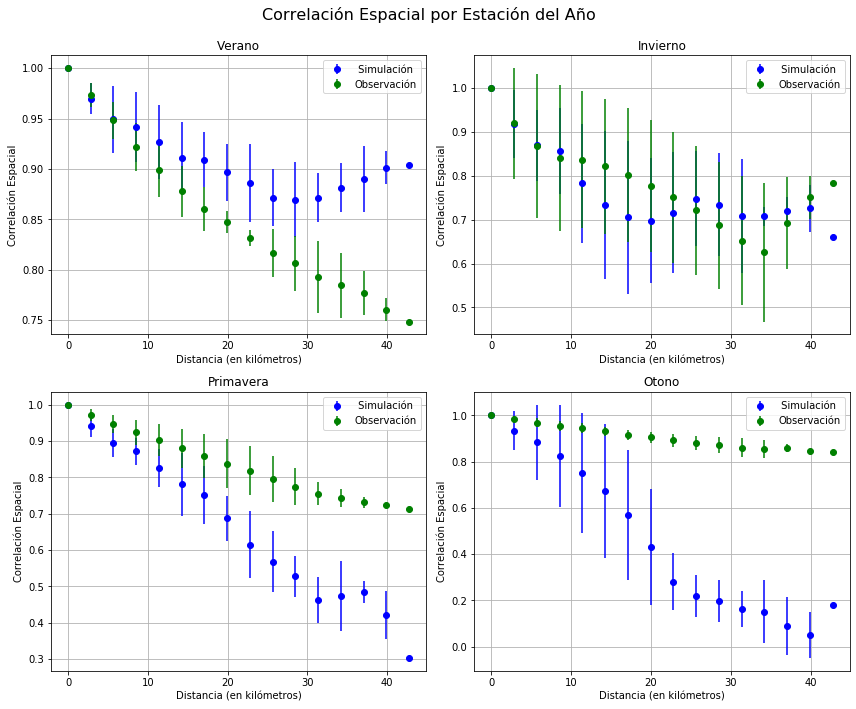

In [14]:
import numpy as np
import xarray as xr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Supongamos que tienes un xarray.Dataset llamado 'filtered_data' con dimensiones x, y y time.
# Supongamos que tienes un diccionario 'result_arrays' donde cada llave es una estación del año ('verano', 'invierno', 'primavera', 'otoño').
# El valor correspondiente a cada llave es un numpy array con los datos de esa estación.

# Nombres de las estaciones del año
estaciones = ['verano', 'invierno', 'primavera', 'otono']

# Configuración general para los subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Correlación Espacial por Estación del Año', fontsize=16)

for i, estacion in enumerate(estaciones):
    # Obtén los datos de la estación actual
    datos = result_arrays[estacion].sum(axis=(0, 2))
    
    datos_reales = filtered_data[estacion]
    datos_reales = datos_reales['__xarray_dataarray_variable__'].values

    # Obtiene las coordenadas x e y desde el xarray.Dataset
    coord_x = filtered_data_verano['x'].values
    coord_y = filtered_data_verano['y'].values

    # Reformatea los datos para que tengan una forma conveniente para calcular la correlación espacial
    datos_reformateados = datos[0]

    # Calcula la matriz de distancias espaciales utilizando pdist y squareform
    coordenadas = np.column_stack((coord_x, coord_y))
    distancias = pdist(coordenadas)
    matriz_distancias = squareform(distancias)

    # Calcula la matriz de correlación espacial
    n_puntos = len(coordenadas)
    matriz_correlacion = np.zeros((n_puntos, n_puntos))
    matriz_correlacion_real = np.zeros((n_puntos, n_puntos))

    for j in range(n_puntos):
        for k in range(n_puntos):
            correlacion = np.corrcoef(datos_reformateados[:, j].flatten(), datos_reformateados[:, k].flatten())
            matriz_correlacion[j, k] = correlacion[0, 1]
            
            correlacion_real = np.corrcoef(datos_reales[:, j].flatten(), datos_reales[:, k].flatten())
            matriz_correlacion_real[j, k] = correlacion_real[0, 1]

    # Calcula la media y desviación estándar de correlaciones para cada distancia
    distancias_aplanadas = np.round(matriz_distancias.flatten()) / 1000
    correlacion_aplanada = matriz_correlacion.flatten()
    correlacion_aplanada_real = matriz_correlacion_real.flatten()

    distancias_unicas = np.unique(distancias_aplanadas)
    media_correlacion_por_distancia = []
    desviacion_estandar_correlacion_por_distancia = []
    
    media_correlacion_por_distancia_real = []
    desviacion_estandar_correlacion_por_distancia_real = []

    for distancia in distancias_unicas:
        mask = (distancias_aplanadas == distancia)
        correlaciones_objetivo = correlacion_aplanada[mask]
        media_correlacion_por_distancia.append(np.mean(correlaciones_objetivo))
        desviacion_estandar_correlacion_por_distancia.append(np.std(correlaciones_objetivo))
        
        correlaciones_objetivo_real = correlacion_aplanada_real[mask]
        media_correlacion_por_distancia_real.append(np.mean(correlaciones_objetivo_real))
        desviacion_estandar_correlacion_por_distancia_real.append(np.std(correlaciones_objetivo_real))

    # Crea el scatter plot con puntos de media y barras de error de desviación estándar en el subplot correspondiente
    row = i // 2
    col = i % 2
    axs[row, col].errorbar(distancias_unicas, media_correlacion_por_distancia, yerr=desviacion_estandar_correlacion_por_distancia, fmt='o', color='blue', label=' Simulación')
    axs[row, col].errorbar(distancias_unicas, media_correlacion_por_distancia_real, yerr=desviacion_estandar_correlacion_por_distancia_real, fmt='o', color='green', label='Observación')
    axs[row, col].set_xlabel('Distancia (en kilómetros)')
    axs[row, col].set_ylabel('Correlación Espacial')
    axs[row, col].set_title(f'{estacion.capitalize()}')
    axs[row, col].grid(True)
    axs[row, col].legend(loc='upper right')

# Ajusta el espaciado entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.savefig('correlación_espacial.png')

# Muestra los subplots
plt.show()

## Plots

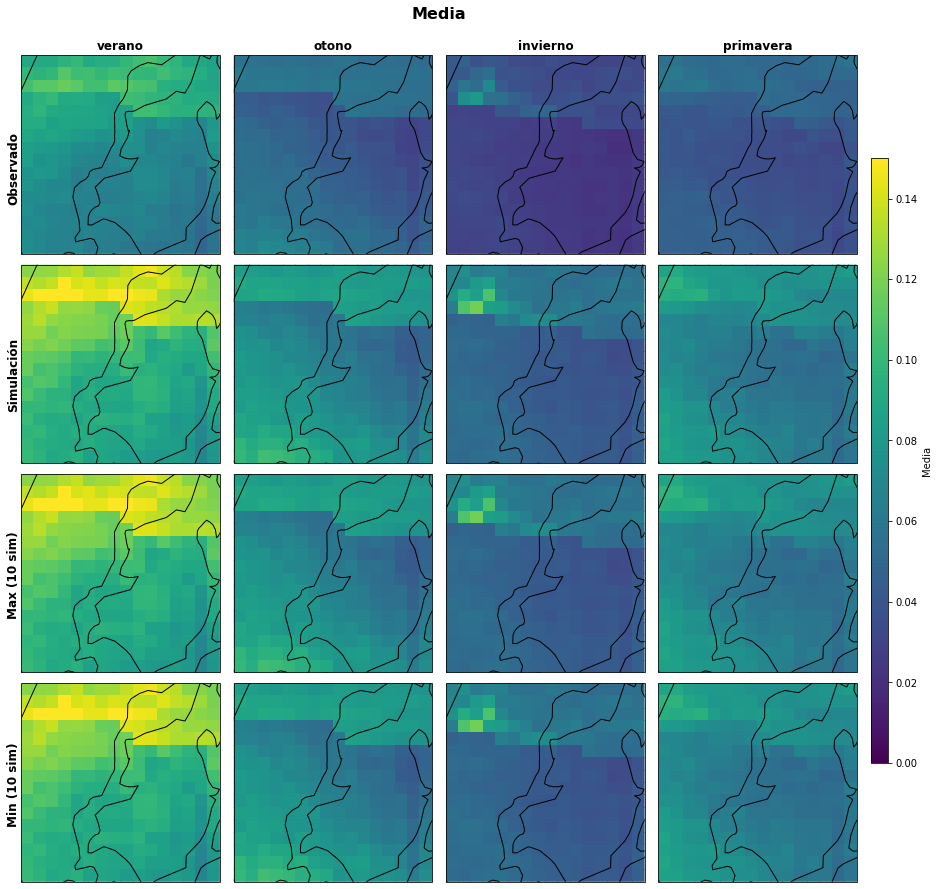

In [13]:
# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Crear una lista de las estaciones
estaciones = list(media_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0
vmax=0.15
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    media_real_data = media_real[estacion]['__xarray_dataarray_variable__']
    media_data = media_datasets[estacion]['__xarray_dataarray_variable__']
    max_media_data = max_media_datasets[estacion]['__xarray_dataarray_variable__']
    min_media_data = min_media_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_media_real = axes[0, col].pcolormesh(media_real_data.x, media_real_data.y, media_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin= vmin, vmax=vmax)
    pcm_media = axes[1, col].pcolormesh(media_data.x, media_data.y, media_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin=vmin, vmax=vmax)
    pcm_max_media = axes[2, col].pcolormesh(max_media_data.x, max_media_data.y, max_media_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_media = axes[3, col].pcolormesh(min_media_data.x, min_media_data.y, min_media_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin= vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
        
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_media_real, cax=cbar_ax, orientation='vertical')
cbar.set_label('Media')

# Agregar título global a la figura
plt.suptitle('Media', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    #fig.text(-0.02, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('media.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

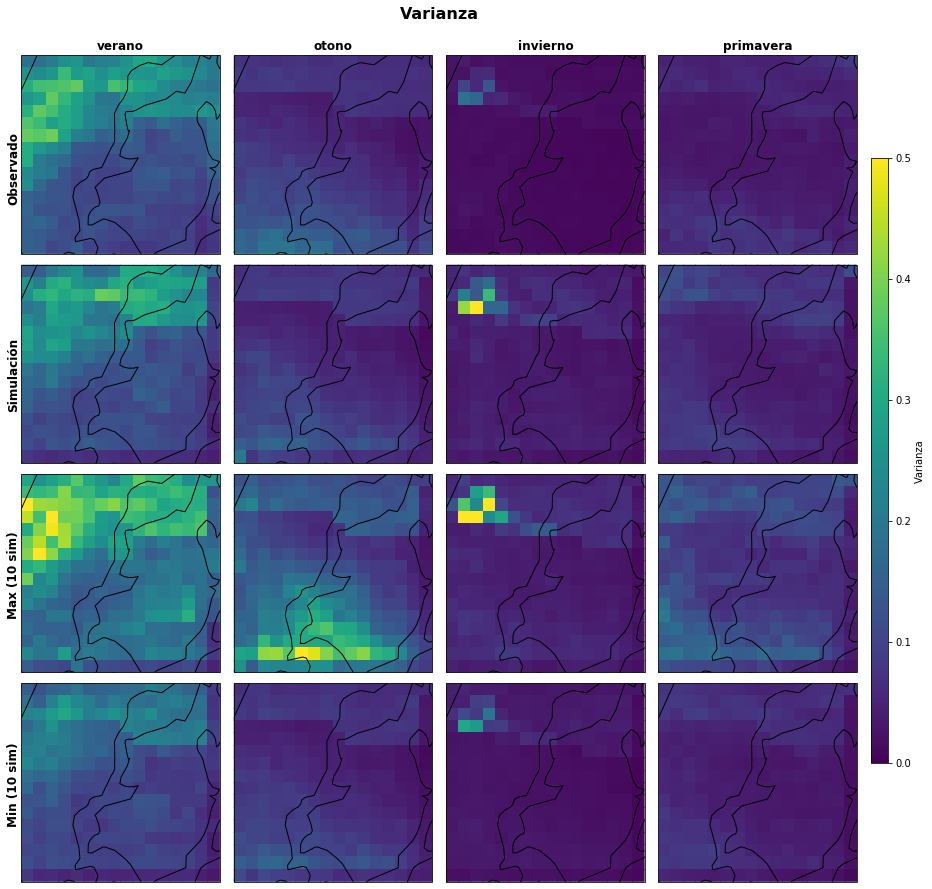

In [14]:
# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Crear una lista de las estaciones
estaciones = list(varianza_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0
vmax=0.5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    varianza_real_data = varianza_real[estacion]['__xarray_dataarray_variable__']
    varianza_data = varianza_datasets[estacion]['__xarray_dataarray_variable__']
    max_varianza_data = max_varianza_datasets[estacion]['__xarray_dataarray_variable__']
    min_varianza_data = min_varianza_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_varianza_real = axes[0, col].pcolormesh(varianza_real_data.x, varianza_real_data.y, varianza_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin= vmin, vmax=vmax)
    pcm_varianza = axes[1, col].pcolormesh(varianza_data.x, varianza_data.y, varianza_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin=vmin, vmax=vmax)
    pcm_max_varianza = axes[2, col].pcolormesh(max_varianza_data.x, max_varianza_data.y, max_varianza_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_varianza = axes[3, col].pcolormesh(min_varianza_data.x, min_varianza_data.y, min_varianza_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin= vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
        
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_varianza_real, cax=cbar_ax, orientation='vertical')
cbar.set_label('Varianza')

# Agregar título global a la figura
plt.suptitle('Varianza', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    #fig.text(-0.02, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('varianza.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

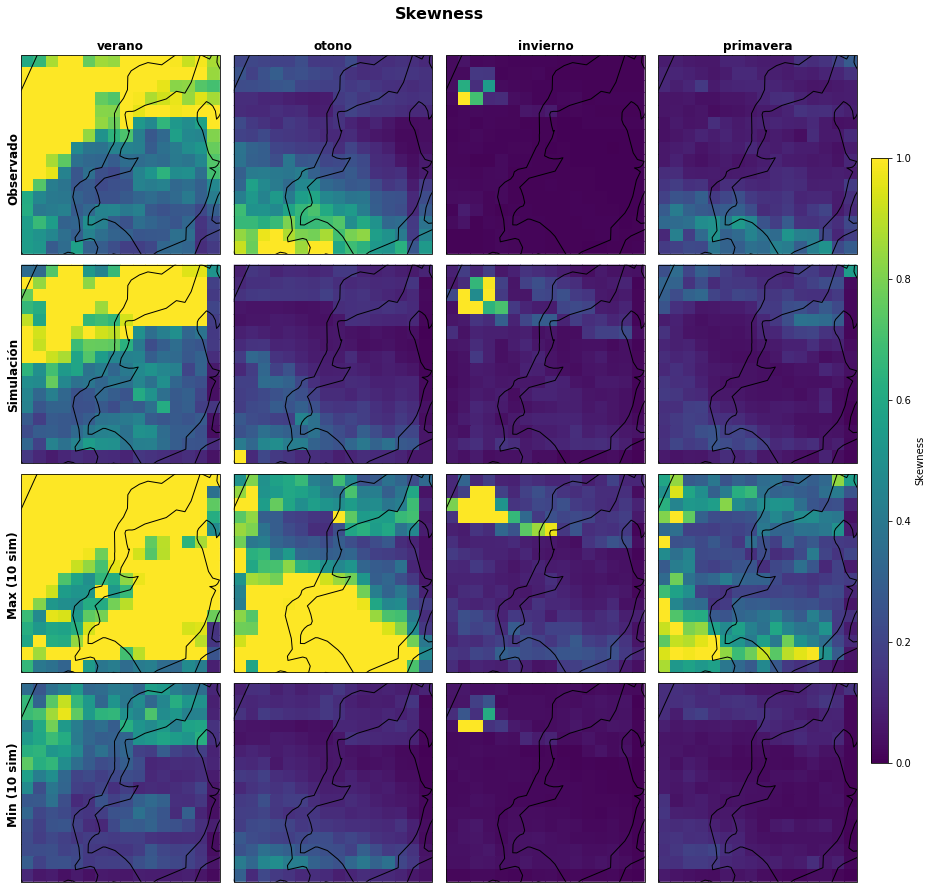

In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")


# Crear una lista de las estaciones
estaciones = list(skewness_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0
vmax=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    skewness_real_data = skewness_real[estacion]['__xarray_dataarray_variable__']
    skewness_data = skewness_datasets[estacion]['__xarray_dataarray_variable__']
    max_skewness_data = max_skewness_datasets[estacion]['__xarray_dataarray_variable__']
    min_skewness_data = min_skewness_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_skewness_real = axes[0, col].pcolormesh(skewness_real_data.x, skewness_real_data.y, skewness_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_skewness = axes[1, col].pcolormesh(skewness_data.x, skewness_data.y, skewness_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_max_skewness = axes[2, col].pcolormesh(max_skewness_data.x, max_skewness_data.y, max_skewness_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_skewness = axes[3, col].pcolormesh(min_skewness_data.x, min_skewness_data.y, min_skewness_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
    
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_skewness_real, cax=cbar_ax, orientation='vertical')
cbar.set_label('Skewness')

# Agregar título global a la figura
plt.suptitle('Skewness', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    #fig.text(-0.02, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('skewness.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

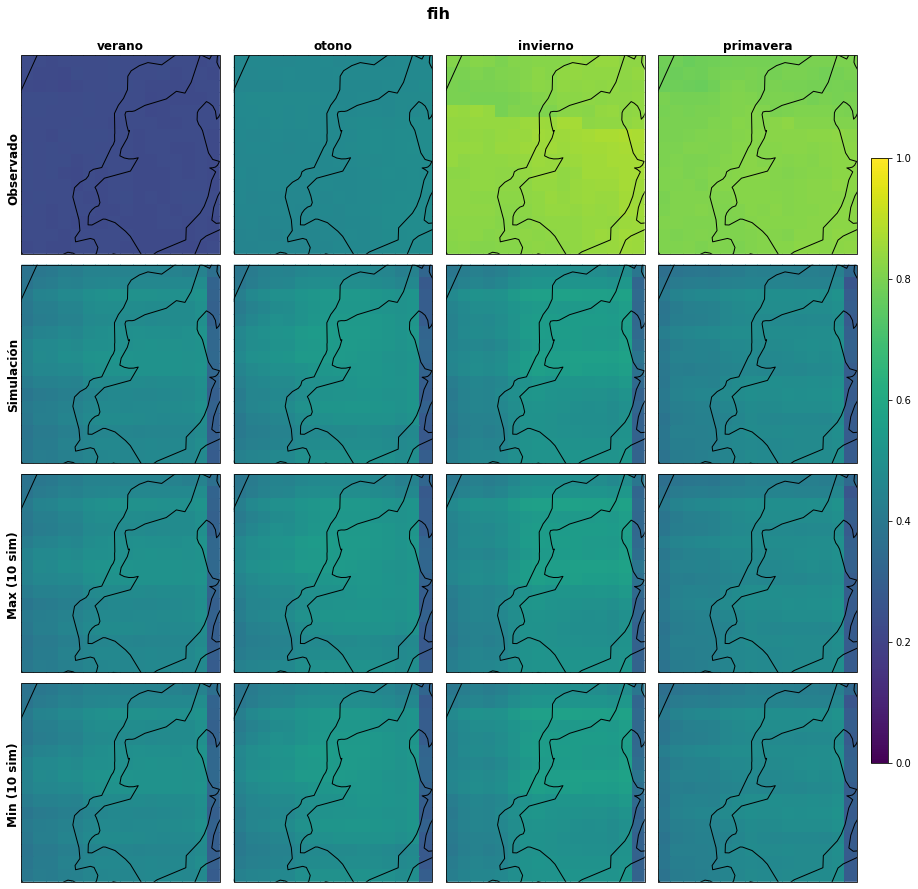

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")


# Crear una lista de las estaciones
estaciones = list(skewness_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0
vmax=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    f1_h_real_data = f1_h_real_datasets[estacion]['__xarray_dataarray_variable__']
    f1_h_data = f1_h_datasets[estacion]['__xarray_dataarray_variable__']
    max_f1_h_data = max_f1_h_datasets[estacion]['__xarray_dataarray_variable__']
    min_f1_h_data = min_f1_h_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_f1_h_real = axes[0, col].pcolormesh(f1_h_real_data.x, f1_h_real_data.y, f1_h_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_f1_h = axes[1, col].pcolormesh(f1_h_data.x, f1_h_data.y, f1_h_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_max_f1_h = axes[2, col].pcolormesh(max_f1_h_data.x, max_f1_h_data.y, max_f1_h_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_f1_h = axes[3, col].pcolormesh(min_f1_h_data.x, min_f1_h_data.y, min_f1_h_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin=vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
    
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_f1_h_real, cax=cbar_ax, orientation='vertical')
#cbar.set_label('Varianza')

# Agregar título global a la figura
plt.suptitle('fih', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    #fig.text(-0.02, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('f1_h.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

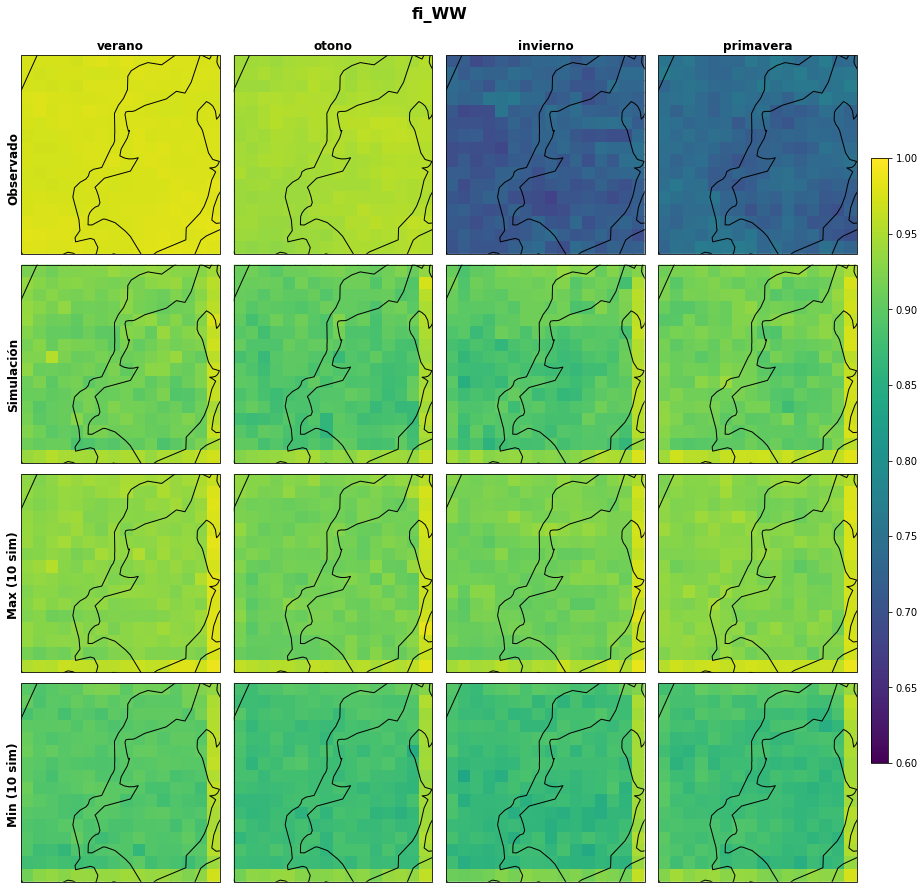

In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")


# Crear una lista de las estaciones
estaciones = list(skewness_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0.6
vmax=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    f1_WW_real_data = f1_WW_real_datasets[estacion]['__xarray_dataarray_variable__']
    f1_WW_data = f1_WW_datasets[estacion]['__xarray_dataarray_variable__']
    max_f1_WW_data = max_f1_WW_datasets[estacion]['__xarray_dataarray_variable__']
    min_f1_WW_data = min_f1_WW_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_f1_WW_real = axes[0, col].pcolormesh(f1_WW_real_data.x, f1_WW_real_data.y, f1_WW_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_f1_WW = axes[1, col].pcolormesh(f1_WW_data.x, f1_WW_data.y, f1_WW_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_max_f1_WW = axes[2, col].pcolormesh(max_f1_WW_data.x, max_f1_WW_data.y, max_f1_WW_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_f1_WW = axes[3, col].pcolormesh(min_f1_WW_data.x, min_f1_WW_data.y, min_f1_WW_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
    
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_f1_WW_real, cax=cbar_ax, orientation='vertical')
#cbar.set_label('Varianza')

# Agregar título global a la figura
plt.suptitle('fi_WW', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('f1_WW.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

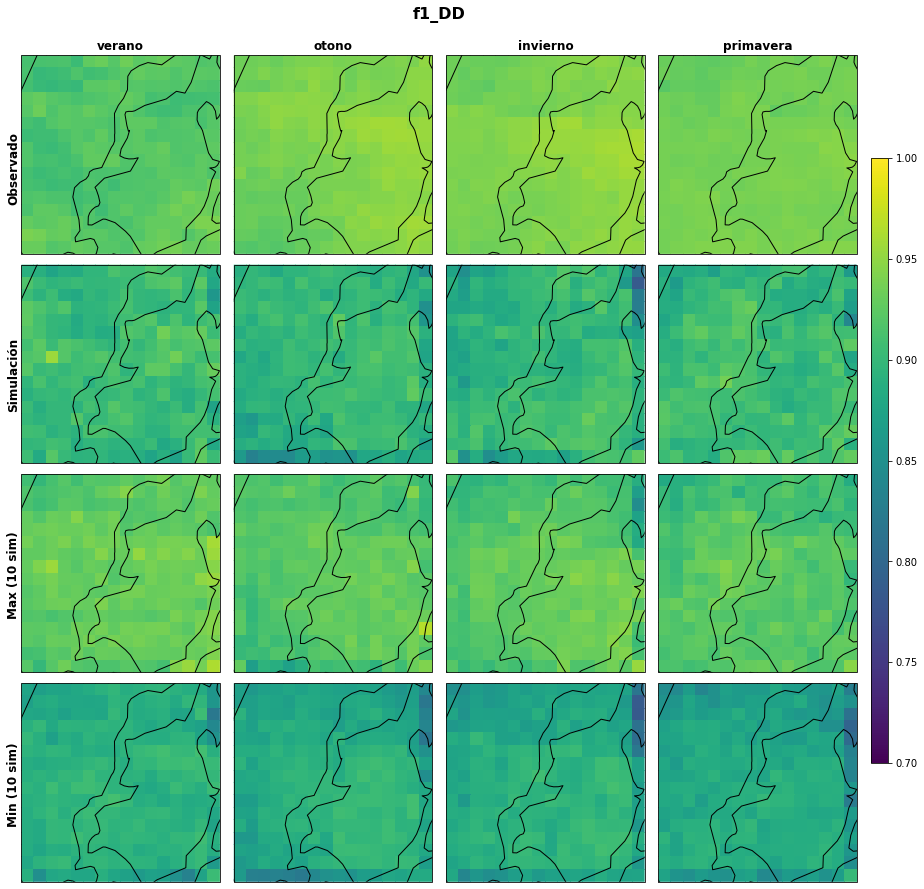

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")


# Crear una lista de las estaciones
estaciones = list(skewness_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0.7
vmax=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})

# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    f1_DD_real_data = f1_DD_real_datasets[estacion]['__xarray_dataarray_variable__']
    f1_DD_data = f1_DD_datasets[estacion]['__xarray_dataarray_variable__']
    max_f1_DD_data = max_f1_DD_datasets[estacion]['__xarray_dataarray_variable__']
    min_f1_DD_data = min_f1_DD_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_f1_DD_real = axes[0, col].pcolormesh(f1_DD_real_data.x, f1_DD_real_data.y, f1_DD_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_f1_DD = axes[1, col].pcolormesh(f1_DD_data.x, f1_DD_data.y, f1_DD_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_max_f1_DD = axes[2, col].pcolormesh(max_f1_DD_data.x, max_f1_DD_data.y, max_f1_DD_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_f1_DD = axes[3, col].pcolormesh(min_f1_DD_data.x, min_f1_DD_data.y, min_f1_DD_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
    
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_f1_DD_real, cax=cbar_ax, orientation='vertical')
#cbar.set_label('Varianza')

# Agregar título global a la figura
plt.suptitle('f1_DD', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('f1_DD.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

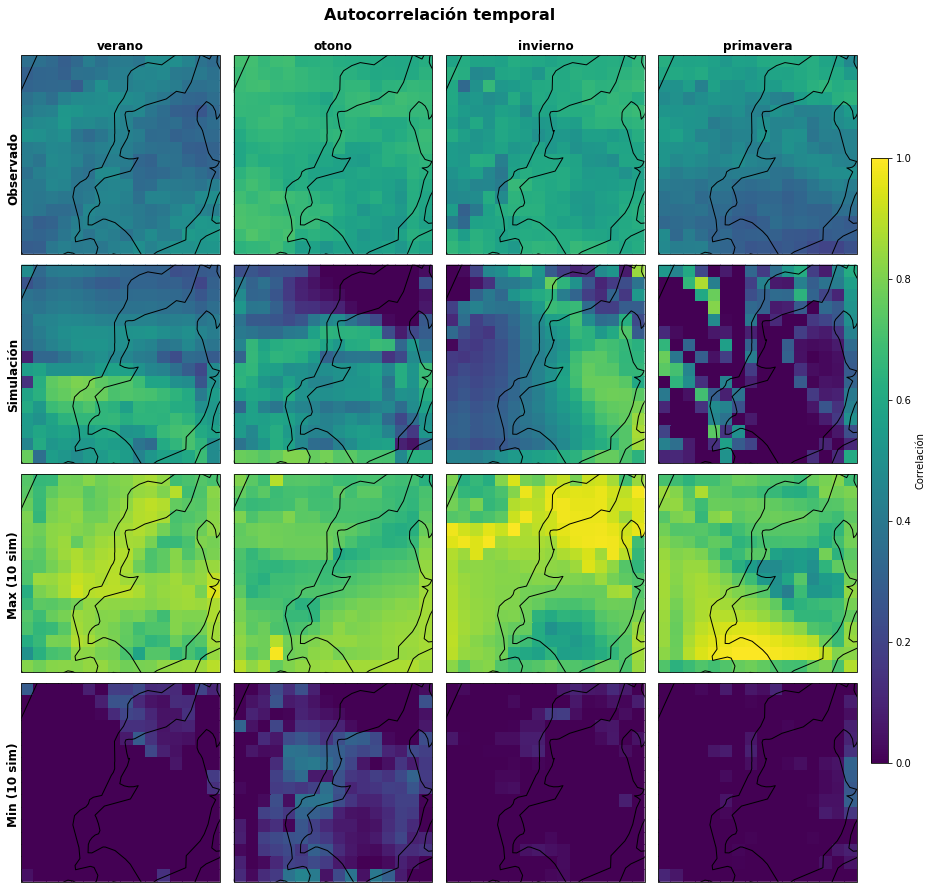

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")


# Crear una lista de las estaciones
estaciones = list(skewness_datasets.keys())

# Configurar las dimensiones de la figura
nrows, ncols = 4, 4
vmin=0
vmax=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), subplot_kw={'projection': ccrs.TransverseMercator()})


# Iterar a través de las estaciones y crear subplots para cada estación
for col, estacion in enumerate(estaciones):
    ax_column = [ax[col] for ax in axes]
    
    # Obtener los datos correspondientes a cada tipo de xarray.Dataset
    autocorr_temp_real_data = autocorr_temp_real_datasets[estacion]['__xarray_dataarray_variable__']
    autocorr_temp_data = autocorr_temp_datasets[estacion]['__xarray_dataarray_variable__']
    max_autocorr_temp_data = max_autocorr_temp_datasets[estacion]['__xarray_dataarray_variable__']
    min_autocorr_temp_data = min_autocorr_temp_datasets[estacion]['__xarray_dataarray_variable__']
    
    # Crear las visualizaciones usando pcolormesh
    pcm_autocorr_temp_real = axes[0, col].pcolormesh(autocorr_temp_real_data.x, autocorr_temp_real_data.y, autocorr_temp_real_data,
                  transform=ccrs.TransverseMercator(), shading='auto',vmin=vmin, vmax=vmax)
    pcm_autocorr_temp = axes[1, col].pcolormesh(autocorr_temp_data.x, autocorr_temp_data.y, autocorr_temp_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_max_autocorr_temp = axes[2, col].pcolormesh(max_autocorr_temp_data.x, max_autocorr_temp_data.y, max_autocorr_temp_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    pcm_min_autocorr_temp = axes[3, col].pcolormesh(min_autocorr_temp_data.x, min_autocorr_temp_data.y, min_autocorr_temp_data,
                  transform=ccrs.TransverseMercator(), shading='auto', vmin=vmin, vmax=vmax)
    
    # Agregar coastlines
    for ax in ax_column:
        ax.coastlines()
        
    # Agregar títulos a cada columna
    axes[0, col].set_title(estacion, fontsize=12, fontweight='bold')
    
# Ajustar espaciado entre subplots
plt.tight_layout()

# Agregar una sola barra de color vertical compartida por todos los subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])  # Ajusta las coordenadas para la ubicación de la barra de color
cbar = plt.colorbar(pcm_autocorr_temp_real, cax=cbar_ax, orientation='vertical')
cbar.set_label('Correlación')

# Agregar título global a la figura
plt.suptitle('Autocorrelación temporal', fontsize=16, fontweight='bold', y=1.025)

# Agregar títulos a cada fila usando fig.text()
for row, titulo_fila in enumerate(['Observado', 'Simulación', 'Max (10 sim)', 'Min (10 sim)']):
    fig.text(0, 0.8 - row * 0.24, titulo_fila, rotation='vertical', fontsize=12, fontweight='bold')

plt.savefig('autocorr_temp.png', dpi=300)
# Mostrar la figura
plt.show()

# Reactivar los warnings
warnings.filterwarnings("default")

## Excedence probability

In [9]:
def exceedence_probability(Serie_Observed, Serie_Simulated, temporal_resolution):
    # Observed
    aux = Serie_Observed.values
    aux = aux[aux>=0]
    s_obs = np.sort(aux, axis=None)[::-1]
    exc_obs = np.arange(1.,len(s_obs)+1) / len(s_obs)

    # Simulated
    if temporal_resolution == 'd':
        units = 'mm/day'
    elif temporal_resolution == 'h':
        units = 'mm/hour'

    #ux = Serie_Simulated.values; aux=aux[aux>=0]
    aux = Serie_Simulated; aux=aux[aux>=0]
    s_sim = np.sort(aux, axis=None)[::-1]
    exc_sim = np.arange(1.,len(s_sim)+1) / len(s_sim)
    
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(exc_obs, s_obs, '.k', markersize=8,  label='Obs')
    ax.plot(exc_sim, s_sim, 'r',  label='Sim')
    ax.set_xlabel("Exceedence Probability", fontsize=13)
    ax.set_ylabel(units, fontsize=13)
    ax.set_xscale('log')
    ax.grid(True)
    ax.tick_params(labelsize=13)
    ax.legend(fontsize = 15)
    
    return fig

/opt/conda/envs/pr-disagg-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


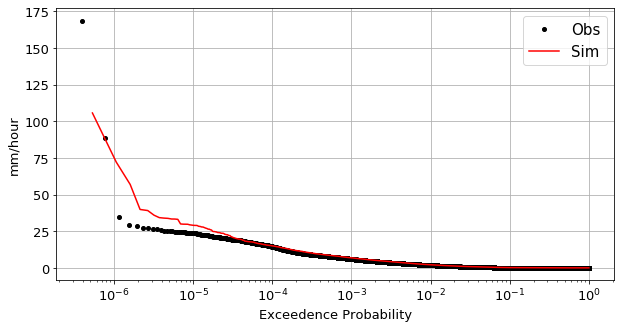

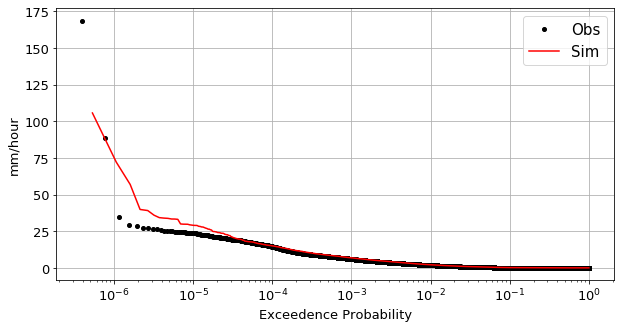

In [25]:
exceedence_probability(filtered_data_otono_hourly['__xarray_dataarray_variable__'], result_arrays['otono'][:, 1], 'h')